# HANDS-ON PRACTICE SESSION 2: CONVOLUTIONAL NEURAL NETWORKS FUNDAMENTALS

SO Basics of Neural Networks 2023 school at the IAA-CSIC. Nov 2023.  
Eduardo Sánchez Karhunen  (fesanchez@us.es)  
University of Seville. Spain.  Dept. of CS and AI

### Introduction

In this second hands-on practice we are going to tackle again the the Galaxy10 classification problem. As a reminder, the Galaxy10 dataset is a collection of 69x69 colored images with 10 mutually exclusive classes. For educational purposes, we will design a CNN (Convolutional Neural Network) form scratch.

### 1. Loading libraries

In [ ]:
import numpy as np
import h5py
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

In [ ]:
# only execute this lines if the following error appears
# OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.

# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Exercise 0: Dataset preparation

As in the previous session, download the dataset to your local disk.

In [ ]:
# LINUX
!wget http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5

# WINDOWS
# !curl "http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5" --output Galaxy10.h5

--2023-11-05 15:43:44--  http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Resolving www.astro.utoronto.ca (www.astro.utoronto.ca)... 128.100.89.92
Connecting to www.astro.utoronto.ca (www.astro.utoronto.ca)|128.100.89.92|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210234548 (200M)
Saving to: ‘Galaxy10.h5.8’

Galaxy10.h5.8       100%[===================>] 200.50M  48.3MB/s    in 4.6s    

2023-11-05 15:43:48 (43.8 MB/s) - ‘Galaxy10.h5.8’ saved [210234548/210234548]


Next, we need to convert the downloaded h5 files into two numpy arrays containing images and labels.

In [ ]:
hf = h5py.File('Galaxy10.h5', 'r')
labels, images = hf.get('ans')[()], hf.get('images')[()]

Check the shape of the dataset: number of images and its shape.

In [ ]:
n_images, *shape, n_channels = images.shape
print(f"number of images: {n_images}")
print(f"shape of each image: {shape}")
print(f"number of channels: {n_channels}")

number of images: 21785
shape of each image: [69, 69]
number of channels: 3


As we have seen in the first session, MLP networks can not handle colored (multichannel) images and we converted them into grayscale. On the contrary, CNN were designed to handle images in a very natural way.

### Exercise 1. Create train and test datasets

Divide the dataset into two new datasets for:
* training: 90%
* test: 10%  

Use the `train_test_split` command from scikit_learn. Do not worry for the validation dataset. We will create it on-the-fly during the model training process.

More info in: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

**Task:** Create the following arrays: `train_images`, `train_labels`, `test_images` and `test_labels`.

In [ ]:
# your code here

from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.1, random_state=42)
train_images, train_labels, test_images, test_labels = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]

### Exercise 2. Normalize image pixel values

Again, we must apply a very simple normalization preprocessing step. e.g. dividing all pixel values by their maximum value: 255.

**Task:** Divide train and test images by 255.0.

In [ ]:
# your code here

train_images = train_images/255.0
test_images = test_images/255.0

### Exercise 3. Building the CNN model

Our next step is to design a CNN to solve the problem. Lets consider a simple 1 stage architecture. Here, one stage means that our implementation contains an single pair of convolutional + pool layers.

* First, we will define the preprocessing stage: 1 conv + 1 pooling layer.

* Secondly, a transition between the preprocessing stage and the final stage is needed: 1 flattening layer.

* Finally, the decision stage will be defined: 1 dense layer + 1 output_layer.


<br>

![picture](https://drive.google.com/uc?id=1k8aHjwHlRP3wgU-IAtpKbcvwqyvvyUwY)


### Exercise 4. First convolutional layer creation.

Remember the first layer in a NN always has to be informed of the shape of the input samples.

As indicated in the image above, our layer parameters are:
* 12 kernels (3x3)
* Stride = 1. The kernel will be shifted pixel by pixel along the image.
* No-padding. In Tensorflow, this is indicated as padding = `valid`.
* There are no indications about the activation function. Hence, we can consider a ReLU.

More details in https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D.

**Task:** Create the convolutional layer for our model

In [ ]:
# your code here

conv_1 = tf.keras.layers.Conv2D(filters=12,               # number of filters (number of kernels)
                                kernel_size=(3, 3),       # kernel shape
                                strides=(1, 1),           # how shift kernel moving along the image
                                padding='valid',          # either to include padding or not
                                activation='relu',        # activation function
                                name='conv_1',
                                input_shape=(69, 69, 3))

### Exercise 5. Pooling layer creation

Once obtained the previous layer has obtained the features, a subsampling is perform. In this case, each 2x2 pixel group will be resumed into a single value (the maximum of the group).

Hence, use the following parameters:
* pool_size = 2x2
* stride = 2
* There is no activation funtion associated to pooling layers.

More info in: https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPooling2D

**Task:** Create the pooling layer for our model

In [ ]:
# your code here

pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
                                      strides=(2, 2),
                                      name='pool_1')

### Exercise 6. Transition between Convs and decision stage

**Task:** Create the flattening layer

In [ ]:
flatten_layer = tf.keras.layers.Flatten()

### Exercise 7. Decision stage: hidden layer creation.

Once the flattened layer has completed its operation, the image has been transformed into a 1D-array.

To determine the number of neurons of the following dense layers we need to know the size of this 1D-array.

* input image = (69, 69, 3)
* after conv = (67, 67, 12)
* after pool = (33, 33, 12)
* flattening = 33 x 33 x 12 = 13.068

After that, a couple of dense layer are defined to reduce the dimensionality of the information from 13.068 to 10.

Remember:
* Follow the idea of a reduction of the dimensionality step by step.
* Hidden layers activation function is always a ReLU family one.

**Task:** Create two dense layers with 500 and 100 neurons, respectively.

In [ ]:
# your code here

dense_1 = tf.keras.layers.Dense(units=500, activation='relu', name='dense_1')
dense_2 = tf.keras.layers.Dense(units=100, activation='relu', name='dense_2')

### Exercise 8. Create the output layer.

Do not forget:
* The number of neurons of this layer is the number of classes.
* Its activation function is sigmoid (if 2 classes) or softmax (if >2 classes)

**Task:** Create the proper output layer

In [ ]:
# Your code here

output_layer = tf.keras.layers.Dense(units=10, activation='softmax', name='output_layer')

### Exercise 9. Join all layers in a CNN

Remember: the first step is to create a `sequential` structure to be filled with the previously created layers.

More info in: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

**Task:** Collect all the previous layers in a model

In [ ]:
# your code here

# input shape: (69,69,3)
model = tf.keras.Sequential()

model.add(conv_1)
# output shape: (67,67,12)

model.add(pool_1)
# output shape: (33,33,12)

model.add(flatten_layer)
# output shape: 13068

model.add(dense_1)
# output shape: 500

model.add(dense_2)
# output shape: 100

model.add(output_layer)
# output shape: 10


### Exercise 10. Model inspection

Show a summary of the model, with info of each layer:
* name and type of layer
* output shape
* number of parameters

This info is useful to check if the model has been built properly and, very important, to be conscious of the huge number of parameters to train.

You should obtain aprox 6,5M of parameters. If we would tackle this problem with MLP we had needed aprox 69 x 69 x3 x 1000

**Task:** show a summary of the network

In [ ]:
# your code here

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 67, 67, 12)        336       
                                                                 
 pool_1 (MaxPooling2D)       (None, 33, 33, 12)        0         
                                                                 
 flatten (Flatten)           (None, 13068)             0         
                                                                 
 dense_1 (Dense)             (None, 500)               6534500   
                                                                 
 dense_2 (Dense)             (None, 100)               50100     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 6585946 (25.12 MB)
Trainable params: 65859

### Exercise 11. Assign loss function and optimizer

Before training a model some details must be set:
* A loss function to be optimized. In classification problems, cross_entropy is considered:
    - 2 classes: binary cross entropy
    - +2 classes: categorical cross entropy

If the class label is not codified using one_hot, we use sparse_categorical_crossentropy.

More info in: https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

* An optimization "technique" to reduce the loss funtion up to a local minimum Typically, an adam optimizer is considered for training DL models.

More info in: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

**Task:** Indicate to the network the selected loss function and optimizer


In [ ]:
# your code here

# model.compile(loss='sparse_categorical_crossentropy',
#              optimizer='adam',
#              metrics=['accuracy'])

# an alternative
loss_function = tf.keras.losses.sparse_categorical_crossentropy
optim = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    loss=loss_function,
    optimizer=optim,
    metrics=['accuracy'])

### Exercise 12. Network training

At this point, two final decision must be taken:
* * How many epochs do we need to used? In this concrete problem, beyond 7-10 epochs there is no improvement.
* A validation dataset must be provided to the model. Typically 20% of the training dataset is more than enough for our purposes. Use the parameter `validation_split` to indicate this value to the model training.

You should obtain an accuracy on the validation dataset around 71-73%

**Task:** Train the model with the selected number of epochs and validation_split parameter.

In [ ]:
# your code here

history = model.fit(train_images, train_labels, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
491/491 [==============================] - 6s 6ms/step - loss: 1.2995 - accuracy: 0.4915 - val_loss: 0.9679 - val_accuracy: 0.6331
Epoch 2/10
491/491 [==============================] - 2s 4ms/step - loss: 0.8548 - accuracy: 0.6889 - val_loss: 0.8466 - val_accuracy: 0.6823
Epoch 3/10
491/491 [==============================] - 2s 4ms/step - loss: 0.7301 - accuracy: 0.7321 - val_loss: 0.8266 - val_accuracy: 0.6928
Epoch 4/10
491/491 [==============================] - 2s 4ms/step - loss: 0.6476 - accuracy: 0.7603 - val_loss: 0.7714 - val_accuracy: 0.7241
Epoch 5/10
491/491 [==============================] - 2s 4ms/step - loss: 0.5534 - accuracy: 0.7971 - val_loss: 0.7539 - val_accuracy: 0.7234
Epoch 6/10
491/491 [==============================] - 2s 4ms/step - loss: 0.4737 - accuracy: 0.8301 - val_loss: 0.8063 - val_accuracy: 0.7244
Epoch 7/10
491/491 [==============================] - 2s 4ms/step - loss: 0.3909 - accuracy: 0.8615 - val_loss: 0.8562 - val_accuracy: 0.7333
Epoch 

### Exercise 13: Plot training history

It is a good practice to plot our training curves. Typically we compare the evolution of loss function (accuracy) vs epochs.

**Task:** Plot train and valid loss (and accuracy) evolution during training

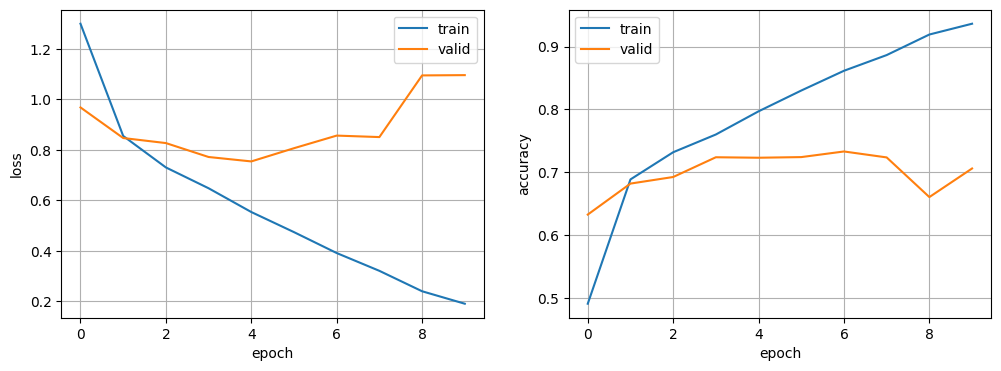

In [ ]:
# your code here

df_1 = pd.DataFrame({'loss_train': history.history['loss'],
                     'loss_valid': history.history['val_loss']
                    })

df_2 = pd.DataFrame({'accuracy': history.history['accuracy'],
                   'accuracy_valid': history.history['val_accuracy']
                   })

data = [df_1, df_2]
y_labels = ['loss', 'accuracy']

f, axs = plt.subplots(1, 2, sharex=True, figsize=(12,4))
for ax, y_label, df in zip(axs, y_labels, data):
    ax.plot(df, label=['train','valid'])
    ax.grid(True)
    ax.set_xlabel('epoch')
    ax.set_ylabel(y_label)
    ax.legend();



### Exercise 14. Evaluate model accuracy

**Task:** Once trained the model, obtain the accuracy of the model on the test dataset.

In [ ]:
# your code here

res = model.evaluate(test_images,test_labels, verbose=0)
print(f"model accuracy: {np.round(res[1],2)}")

model accuracy: 0.68


### Exercise 8: Making predictions with the model

Given an input image, the `predict` method returns the output of the last layer. This output is interpreted as the probability of the image to correspond to each of the classes.

**Task:** Inject to the model 3 images from the test dataset to obtain their probabilities.

In [ ]:
# your code here

X_new = test_images[:10]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 96ms/step


array([[0.66, 0.28, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.51, 0.36, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  ],
       [0.  , 0.01, 0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.3 , 0.09, 0.16, 0.  , 0.02, 0.  , 0.  , 0.  , 0.34, 0.08],
       [0.38, 0.  , 0.34, 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.02],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.26, 0.74, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.16, 0.46, 0.  , 0.  , 0.  , 0.  , 0.  , 0.34, 0.03, 0.  ]],
      dtype=float32)

**Task:** Using `np.argmax` and the probabilities, decide which is the class of each image

In [ ]:
# your code here

y_predicted = np.argmax(y_proba.round(2), axis=1)
y_predicted

array([0, 1, 0, 2, 8, 0, 2, 2, 2, 1])

**Task:** Finally, compare the predicted classes with the real ones. There should be approx. 2/3 of correct predictions.

In [ ]:
# your code here

test_labels[:10]

array([0, 1, 1, 1, 1, 2, 2, 2, 2, 7], dtype=uint8)